## Filtro digital
Este método permitirá implementar un filtro aplicable para restringir las bandas de frecuencias con las que se van a trabajar.
En principio, se aplicará un filtro '*lowpass*' a los datos de entrada para evitar artefactos producidos por el Aliasing debido a componentes de alta frecuencia antes de realizar el remuestreo.
En segunda instancia, se aplicará el filtro '*hipass*' para los datos objetivo con el fin de producir bandas de alta frecuencia a partir de la información proporcionada por los datos de entrada.

In [331]:
import scipy.signal as signal

filter_order=8 #orden del filtro
max_ripple=5 #Rizado máximo
freq_sample=22050 #Frecuencia de muestreo
filter_type='highpass' #Tipo de filtro

def apply_filter_low(x, crit_freq):
    sos = signal.cheby1(filter_order, max_ripple, crit_freq-1, 'lowpass', fs=freq_sample, output='sos')
    return signal.sosfilt(sos, x)


In [332]:

def apply_filter_high(x, crit_freq):
    sos = signal.cheby1(filter_order, max_ripple, crit_freq, 'highpass', fs=freq_sample, output='sos')
    return signal.sosfilt(sos, x)

## Carga de datos

Dichas funciones se definieron para crear varios segmentos a partir de los datos de audio de un archivo.

In [333]:
import numpy as np
def check_div(data, div):
  if data.shape[0] % div != 0:
    data = np.append(data, np.zeros(div - data.shape[0] % div))
  return data

def load_data(path):
  fs, data = wav.read(path)
  if len(data.shape)>1:
    if data.shape[1] > 1:
      data = (data[:,0] + data[:,1]) / 2
  data = data/np.max(np.abs(data))
  data = np.clip(data, -1, 1)
  return data.astype(np.float32), fs

def process_data(data, seg_size, normalize=False):
  data = check_div(data, seg_size)
  num_batches = data.shape[0]//seg_size
  if normalize:
    data = (data + 1) / 2
  data = np.reshape(data, newshape=(num_batches, seg_size, 1))
  #nulls = np.ones_like(data)/2
  #data = np.concatenate((data, nulls), axis=1)
  return data

def save_data(data, fs, name_file, normalize = False):
  if len(data.shape)>1:
    data = np.reshape(data, newshape=(data.shape[0]*data.shape[1],))
  if normalize:
    data = (data * 2) - 1
  data = data.astype(np.float32)
  wav.write(name_file, fs, data)

In [334]:
# from google.colab import drive
# drive.mount('/content/drive')

In [335]:
num_resources = 100
prefixes = ['blues',
            'classical',
            'country',
            'disco',
            'hiphop',
            'jazz',
            'metal',
            'pop',
            'reggae',
            'rock']
chunk_size = 4096
path = 'dataset/'


filters_size = 5


## Modelo generativo

El modelo recibirá como entrada los datos con baja tasa de muestreo, se comprimirán a través del codificador automático y se reconstruirá una banda de alta frecuencia a partir del tensor del espacio latente.

In [336]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, Sequential
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Función Downsampling

Genera bloques compuestos por capas de configuración: Conv1D - BatchNorm - ReLU.

La configuración se inspira en la arquitectura Pix2Pix. Este diseño realiza una operación Convolucional (con un desplazamiento de 2 muestras para generar un tensor con la mitad del tamaño) sobre el tensor de entrada para obtener mapas de características, los cuales posteriormente son procesados por la capa BatchNormalization. Esta última se encarga de normalizar los valores que serán entregados a la función de activación, con la restricción de mantener la media en 0 y la desviación estándar en 1.

La función de activación se encarga de aportar el componente de no-linearidad dentro de un dominio dado. En este caso, se opta por una capa ReLU, la cual proporciona una activación solo para valores mayores a 0.

El inicializador de parámetros es una función que produce dentro de los tensores una distribución normal aleatoria de valores. Si bien, los Modelos, al definirse, son sistemas considerados en un estado de alta entropía, es importante que los parámetros se encuentren inicializados con cierta restricción. Esta medida se toma para garantizar que los pesos se ajustan gradualmente desde posiciones similares sin que exista más prioridad para unos que para otros desde un comienzo.



In [337]:
initializer = tf.random_normal_initializer(0., 0.1)
def downsample(n_filters, size,  batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv1D(filters=n_filters,
                             kernel_size=(size,),
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias = True
                            ))
  if batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU(0.2))

  return result

## Función Upsampling

Similar al bloque Downsampling, realiza una operación Convolucional traspuesta con un desplazamiento de dos muestras para producir tensores con el doble de tamaño.

Este bloque incluye la opción de Dropout, implementada en el modelo Pix2Pix original, cuyo uso está destinado a evitar el sobre ajuste dentro de las capas del decodificador.

In [338]:
def upsample(n_filters, size, dropout=False, batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv1DTranspose(n_filters,
                                    kernel_size=(size,),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=initializer
                                   ))

  if batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if dropout:
      result.add(tf.keras.layers.Dropout(0.3))

  result.add(tf.keras.layers.ReLU())

  return result

In [339]:

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.oversampled = [
      #downsample(64, filters_size),                  #i: 88200 Hz; o: 44100 Hz
      downsample(64, filters_size),                   #i: 44100 Hz; o: 22050 Hz       
    ]
    
    self.down_b=[          
      downsample(64, filters_size),                         #i: 22050 Hz; o: 11025 Hz
      downsample(32, filters_size),                         #i: 11025 Hz; o: 5512.5 Hz
      downsample(32, filters_size),                          #i: 5512.5 Hz; o: 2756.25 Hz
      downsample(16, filters_size),                          #i: 2756.25 Hz; o: 1378.125 Hz
      
    ]

    self.up_b=[
      upsample(32, filters_size),                           # i: 1378.125 Hz; o: 2756.25 Hz
      upsample(32, filters_size),                          # i: 2756.25 Hz; o: 5512.5 Hz
      upsample(64, filters_size),                          # i: 5512.5 Hz; o: 11025 Hz
    ]

    self.last = keras.Sequential()
    self.merge = keras.Sequential()



    self.merge = upsample(64, filters_size)  # i: 11025 Hz; o: 22050 Hz      

    self.last.add(keras.layers.Conv1D(filters=1,
                                      kernel_size=(filters_size,),
                                      strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='sigmoid'
                                      ))
  

  def call(self, x):
    skip_connections = []
    x = self.oversampled[0](x)
    #x = self.oversampled[1](x)
    prior_info = x    
    for down in self.down_b:
      x = down(x)
      skip_connections.append(x)
    
    skips = reversed(skip_connections[:-1])

    for up, skip in zip(self.up_b, skips):
      x = up(x)
      x = keras.layers.Concatenate()([x, skip])

    x = self.merge(x)
    x = keras.layers.Concatenate()([x, prior_info])
    x = self.last(x)
    return x

generator = Generator()

In [340]:
def feature_map(n_filters, size,  batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv1D(filters=n_filters,
                             kernel_size=(size,),
                             strides=1,
                             padding='same',
                             kernel_initializer=initializer
                            ))
  if batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU(0.3))

  return result

## Discriminador

Se trata de un modelo convolucional que realizará operaciones de extracción de características con el objetivo de hacerlas converger en un vector denominado como '*parche*' (De ahí que estos modelos generativos se denominen de tipo PATCH-GAN). Su tensor de entrada se compone del resultado obtenido del generador, concatenado con el objetivo. Si el resultado del Generador se parece mucho al objetivo, entonces el Discriminador deberá generar, idealmente, un vector de 1's. En caso contrario, será un vector de 0's.

In [341]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.down_b=[          
      downsample(16, filters_size),                           #(8192, 32)
      downsample(32, filters_size),                           #(4096, 64) 
      downsample(64, filters_size),                           #(2048, 128)
      downsample(128, filters_size),                          #(1024, 256)
      #feature_map(256, filters_size),                          #(512, 256)
      #downsample(512, filters_size),                          #(256, 512)
      #downsample(512, filters_size),                          #(128, 512)

      keras.Sequential([keras.layers.Conv1D(filters=1,
                                            kernel_size=(filters_size,),
                                            strides=1,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')])
    ]


  def call(self, x):
    x = keras.layers.Concatenate()([x[0], x[1]])
    for down in self.down_b:
      x = down(x)
      
    return x

discriminator = Discriminator()
#discriminator = keras.models.load_model('Results/Models/discriminator.tf')

## Funciones de coste

La función de coste/pérdida se encarga de calcular el grado de error que produce el Modelo al comparar el resultado producido por este, respecto a un resultado objetivo o "ideal".

La función de Error Absoluto Medio se aplica sobre la función de coste del Generador para aproximar el resultado predicho con el objetivo para evitar que el modelo intente reducir el error con resultados que disten del producto esperado.

La función Entropía Cruzada Binaria describe la probabilidad de que un resultado sea catalogado como correcto o falso (1 o 0, respectivamente). Este se aplica sobre el resultado producido por el Discriminador, el cual genera un vector con una descripción abstracta de las regiones que más se parecen del resultado del generador al objetivo.

Esta función se aplica de tres maneras distintas:
1. Sobre el modelo generativo. Cuando el modelo generativo produce una salida, esta la envía al Discriminador junto con el objetivo para obtener el '*parche*' que describe la relación entre uno y otro (los valores del vector producido por el Discriminador se aproximarán a 1 si el resultado se parece al objetivo). En este caso, la función BCE(Entropía Cruzada Binaria, por sus siglas en inglés: Binary Cross Entropy), computará la pérdida que existe dado el resultado del discriminador y un tensor de 1's con la misma forma. El objetivo del generador es reducir dicha pérdida.

2. Sobre el modelo discriminador. La segunda forma en que se aplica es ajustando el discriminador para producir vectores de unos cuando ambas entradas son muy parecidas o iguales. Para ello, se ingresa al discriminador dos veces el objetivo y la función BCE computa la pérdida con relación a un tensor de 1's, de esta forma se condiciona al Discriminador para evaluar como verdaderos aquellos vectores que se parezcan más al objetivo. Por otra parte, el Discriminador también tiene la tarea de adquirir un criterio estricto sobre las evaluaciones que realiza sobre los resultados que produce el generador. Por ello, la tercer forma en que se aplica esta función de pérdida es al ingresar el resultado del Generador acompañado del objetivo al Discriminador. En este caso, se condiciona al Discriminador para maximizar la pérdida del Generador y obligarle a realizar aproximaciones cada vez más acertadas al objetivo, por lo que la función de coste computará el resultado con respecto a un tensor de 0's.



In [342]:
bce = keras.losses.BinaryCrossentropy()
mae = keras.losses.MeanAbsoluteError()


ALPHA = 150 #Penalización MSE

def gen_loss(disc_out, gen_out, gen_target):

  l_disc = bce(tf.ones_like(disc_out), disc_out)
  l_gen = mae(gen_target, gen_out)

  return l_disc, l_gen * ALPHA


In [343]:
BETA = 3 #Penalización para BCE
def disc_loss(disc_out, disc_target):
  l_target = bce(tf.ones_like(disc_target), disc_target)
  l_real = bce(tf.zeros_like(disc_out), disc_out)

  return l_target, l_real

## Optimizadores

Son funciones encargadas de realizar el proceso de actualización de las variables entrenables dentro de los modelos. Para los procesos de optimización se utilizó el algoritmo Adam, el cual proporciona una estimación adaptativa para el cálculo de los gradientes. Esto permite que el algoritmo evite estancamientos en mínimos locales de la función de coste.

Se crearon dos optimizadores, cada uno encargado de actualizar los pesos de los modelos Generador y Discriminador respectivamente.

In [344]:
g_optim = keras.optimizers.Adam(4e-4)
d_optim = keras.optimizers.Adam(2e-4)

## Función de ajustes

Se encarga de evaluar los modelos, llamar las funciones de coste para obtener los valores de pérdida, computar y aplicar los gradientes a los pesos de los modelos.

In [345]:
finish_train = False
min_gen = 0.5

def train_step(input, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    

    gen_output = generator(input, training=True)

    disc_target = discriminator([target, target], training=True)

    disc_out = discriminator([gen_output, target], training=True)

    generator_losses = gen_loss(disc_out, gen_output, target)

    discriminator_losses = disc_loss(disc_out, disc_target)

    disc_total = discriminator_losses[0] + discriminator_losses[1]

    gen_total = generator_losses[0] + generator_losses[1]  

    
  gen_gradients = gen_tape.gradient(gen_total, generator.trainable_variables)

  disc_gradients = disc_tape.gradient(disc_total, discriminator.trainable_variables)

  g_optim.apply_gradients(zip(gen_gradients, generator.trainable_variables))

  d_optim.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))


  return generator_losses, discriminator_losses

## Función generadora de señales
Se implementó únicamente como elemento demostrativo del progreso de entrenamiento, pruebas preliminares y exponer resultados.
Por cuestiones de precisión, elespectrograma abarca el segmento completo de la señal, mientras que la función solo una porción para observarla con mayor detalle.

In [346]:
from scipy.signal import stft
import matplotlib.pyplot as plt
def generate_signal(test_input, test_target, status=False):
  test_input = test_input[tf.newaxis, ...] #16384
  target = test_target[tf.newaxis,...]  #8192

  prediction = generator(test_input, training=status)#8192
  # seg = prediction.shape[1]//32 
  plt.figure(figsize=(16, 4))

  # stft_input = stft(test_input[0,:,0], 22050*4, nperseg=seg*4)
  # stft_target = stft(target[0,:,0], 22050, nperseg=seg)
  # stft_predicted = stft(prediction[0,:,0], 22050, nperseg=seg)
  
  # stft_list = [stft_input[2], stft_target[2], stft_predicted[2]]
  signal_list = [test_input[0], target[0], prediction[0]]
  title = ['Input Signal', 'Target Signal', 'Predicted Signal']
  color = ['b', 'g', 'r']


  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.plot(signal_list[i][:signal_list[i].shape[0]//8], color[i])

  # plt.subplot(2, 3, 4)
  # plt.pcolormesh(stft_input[1], stft_input[0], np.abs(stft_input[2]), shading='nearest')
  # plt.ylim((0, (2*11025)/3))

  # for i in range(4,6):
  #   plt.subplot(2, 3, i+1)
  #   plt.pcolormesh(stft_target[1], stft_target[0], np.abs(stft_list[i-3]), shading='nearest')
  #   #plt.axis('off')
  plt.show()

## Históricos

Función encargada de imprimir las métricas obtenidas de cada una de las funciones de pérdida con el objetivo de monitorizar el progreso del modelo en general, realizar anotaciones sobre los comportamientos observados y aplicar mejoras.
La ventana de los históricos está limitada a 200 pasos.

In [347]:
g_mae = []
g_bce = []
d_real = []
d_target = []
v_steps = []

def plot_historics(gen_, disc_, step, window):
  g_mae.append(gen_[1].numpy())
  g_bce.append(gen_[0].numpy())

  d_real.append(disc_[1].numpy())
  d_target.append(disc_[0].numpy())

  v_steps.append(step)

  if len(g_mae) > window//2:
    v_steps.pop(0)
    g_mae.pop(0)
    g_bce.pop(0)
    d_real.pop(0)
    d_target.pop(0)

  g_total = np.array(g_mae) + np.array(g_bce)
  d_total = np.array(d_real) + np.array(d_target)

    
  historics = [g_mae, g_bce, g_total, d_real, d_target, d_total]
  title = ['Generator: MSE', 'Generator: BCE', 'Generator: Total','Discriminator: Real', 'Discriminator: Target', 'Discriminator: Total']
  color = ['b', 'g', 'r', 'c', 'm', 'y']

    
  plt.figure(figsize=(16, 4))
  for i in range(6):
      plt.subplot(2, 3, i+1)
      plt.plot(v_steps, historics[i], color[i], label=title[i])
      plt.legend(loc='best')
  plt.show()

In [348]:
def clear_historics(h):
  for i in range(len(h)):
    h[i] = []
  return h

## Función de entrenamiento

Llama al grupo de funciones necesarias para llevar a acabo el entrenamiento, así como muestra los distintos gráficos y métricas.
Cada n pasos intercambia el segmento de señal demostrativa para ilustrar el progreso de entrenamiento.


In [349]:
from sklearn.utils import shuffle
def fit(input, target, inp_test, tg_test, batch):
  b_size = 40
  iterations = input.shape[0]//b_size
  step = 0
  n_s = 0

  for i in range(iterations):

    g_loss, d_loss = train_step(input[i*b_size:(i+1)*b_size], target[i*b_size:(i+1)*b_size])

    if i % 10 == 0:

      display.clear_output(wait=True)
      generate_signal(inp_test[n_s], tg_test[n_s], status=True)
      plot_historics(g_loss, d_loss, step, window=200)
      print(f'Batch: {batch} -- Step: {i+1}/{iterations} || Gen [MAE: {g_loss[1]} -- BCE {g_loss[0]}] || Dis [Target: {d_loss[0]} -- Real: {d_loss[1]}]')

    if i % 60 == 0:
      n_s += 1
    step += 1





## Preprocesamiento

En esta función se aplica el filtro pasa-bajas a las señales de audio y el efecto de remuestreo para preparar los datos de entrenamiento.
En este ejemplo, se pretende realizar un escalamiento de x4.

In [350]:
scaling=4
freq_sample=22050
critical_freq=freq_sample/(2*scaling)

def preprocessing(x):
  filtered = apply_filter_low(x, 11025/2)
  resampled = signal.resample(filtered, int(len(x)//2))
  resampled = signal.resample(resampled, 2*int(len(x)))
  return resampled




## Definición de nombres

Crea un arreglo que recopila los nombres de los archivos necesarios para crear un lote de entrenamiento.

In [351]:
def define_names(since, to):
  
  names = []
  for prefix in prefixes:
    for n in range(since, to):
      if n < 10:
        number = '0' + str(n)
      else: 
        number = str(n)
      print(f'Registered: {prefix}.000{number}.wav')
      names.append(f'{prefix}.000{number}.wav')
  return names

## Inicializador de datos

Se encarga de calcular el tamaño del lote en base al número de lotes solicitados. Carga los archivos de audio definidos en la función anterior, preprocesa el grupo de baja resolución y divide el lote en proporción 80:20 para los grupos entrenamiento y verificación, respectivamente.

In [352]:
from scipy.io import wavfile as wav
from IPython import display

num_batches = 25
load_size = num_resources//num_batches

fs = 22050
reason = 0.8

x_target = None
x_train = None
x_test = None
x_test_target = None


def init_data(names):

  x_target = []
  x_train = []

  for index, name in enumerate(names):
    display.clear_output(wait=True)
    print(f'Loading: {name} -- {index + 1}/{len(names)}')

    data_high, fs = load_data(path + name)

 

    data_low = preprocessing(data_high) 

    high_batch = process_data(data_high, seg_size=chunk_size, normalize=True)

    low_batch = process_data(data_low, seg_size=chunk_size*2, normalize=True)

    for high, low in zip(high_batch, low_batch):
      x_target.append(high)
      x_train.append(low)

  x_target = np.array(x_target)
  x_train = np.array(x_train)


  x_test = x_train[int(x_train.shape[0] * reason):]
  x_test_target = x_target[int(x_target.shape[0] * reason):]

  x_target = x_target[:int(x_target.shape[0] * reason)]
  x_train = x_train[:int(x_train.shape[0] * reason)]


  x_test, x_test_target = shuffle(x_test, x_test_target)
  x_train, x_target = shuffle(x_train, x_target)

  print(f'Train {x_train.shape}')
  print(f'Target {x_target.shape}')
  print(f'Train_test {x_test.shape}')
  print(f'Target_test {x_test_target.shape}')
  
  return x_train, x_target, x_test, x_test_target

## Loop principal

Este ciclo itera sobre el número de lotes que se haya definido. Obtiene la lista de nombres de los archivos, genera los datos y ejecuta la función para aplicar la secuencia de entrenamiento. Este proceso se repite tantas veces como lotes se hayan definido para evitar que se agote la memoria disponible en la GPU.

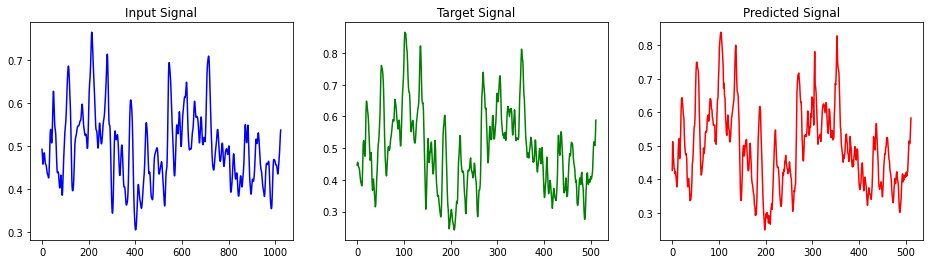

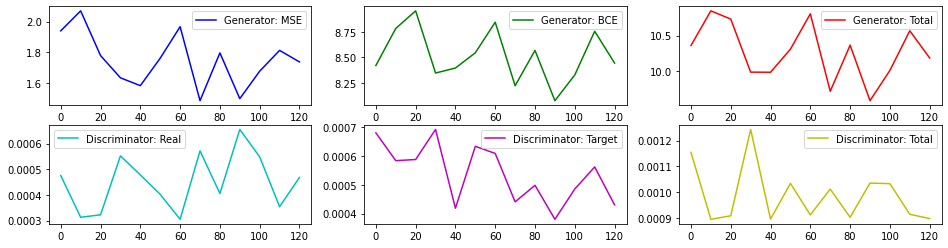

Batch: 24 -- Step: 121/129 || Gen [MAE: 1.7378538846969604 -- BCE 8.442678451538086] || Dis [Target: 0.00043023150647059083 -- Real: 0.0004682034195866436]


In [353]:

for i in range(num_batches):
  g_mae, g_bce, d_real, d_target, v_steps = clear_historics([g_mae, g_bce, d_real, d_target, v_steps])
  names = define_names((i*load_size), ((i+1)*load_size))
  x_train, x_target, x_test, x_test_target = init_data(names)
  fit(x_train, x_target, x_test, x_test_target, i)


In [354]:
generator.save('Results/Models/generator_4.tf', save_format='tf')
discriminator.save('Results/Models/discriminator_4.tf', save_format='tf')

INFO:tensorflow:Assets written to: Results/Models/generator_4.tf\assets
INFO:tensorflow:Assets written to: Results/Models/discriminator_4.tf\assets
